In [12]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

#### 1.	Select Important Features and create a dataframe (4)

In [2]:
df = pd.read_csv('preprocessed_stroke_data.csv')
df.drop(columns='id',inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,has_diabetes,is_obese
0,1,1.735550,0,1,1,2,0,0.638928,0.714365,2,1,0,1
1,1,1.469312,1,1,1,2,0,-0.944196,-0.062848,2,1,0,0
2,0,1.247446,0,0,0,2,1,0.129483,-0.763864,2,1,0,0
3,0,0.803716,0,0,1,2,0,-0.676439,0.164713,0,1,0,0
4,0,1.646804,0,0,1,2,1,-1.453200,-0.550511,0,1,0,0


#### 1.	Split Data to train, test, validate (3)

In [5]:
X = df.drop(['stroke'], axis = 1)
Y = df['stroke']

In [7]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [9]:
X_resampled, y_resampled = smote.fit_resample(X, Y)

#### 2.	Train Model With SMOTE

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X_resampled,y_resampled,test_size=0.25,random_state=27)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

#### 3.	Test Model

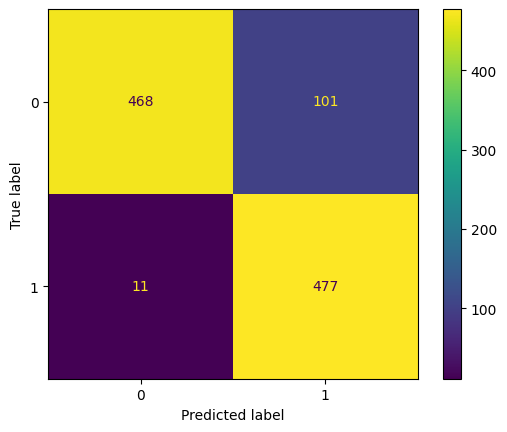

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

#### 4.	Evaluate Model using evaluation matrices

In [15]:
report = classification_report(Y_test, pred, labels=knn.classes_)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       569
           1       0.83      0.98      0.89       488

    accuracy                           0.89      1057
   macro avg       0.90      0.90      0.89      1057
weighted avg       0.91      0.89      0.89      1057



#### 1.	Hyper Parameter tuning to improve performance

In [18]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],        
    'weights': ['uniform', 'distance']  
}

grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, Y_test)
print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)


Best Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Best Model Accuracy: 0.9176915799432356


#### 2.	Save Model to a pickle file 

In [22]:
filename = 'KNN.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

#### 3.	Predict values for validate set using pickle file

In [23]:
with open('KNN.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
pred_validate = loaded_model.predict(X_validation)

In [24]:
X_validation.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,has_diabetes,is_obese
6346,0,-0.301459,0,0,1,2,0,-0.582694,0.262306,2,0,0
6142,1,1.637211,0,1,1,2,0,2.067694,-0.187706,3,0,0
4716,0,1.542959,0,0,1,0,0,0.802337,-0.029562,0,0,0
4665,1,1.546795,0,0,1,2,1,0.577665,-0.812456,0,0,0
1030,1,0.404359,0,0,1,2,1,0.531119,0.196223,3,0,0


#### 4.	Write validate set along with it's predicted values to csv file 

In [25]:
# Create a DataFrame for the validation set along with the predicted values
validation_df = pd.DataFrame({
    'Predicted Value': pred_validate,
    'Actual Value': Y_validation,
})

# Save the DataFrame to a CSV file
validation_df.to_csv('validation_results.csv', index=False)